Selected Classes: ['n02124075', 'n03617480']
Class Indices: [32, 112]
Total samples after filtering: 1000


/home/krp5448/.local/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Reduced data shape: (1000, 6)


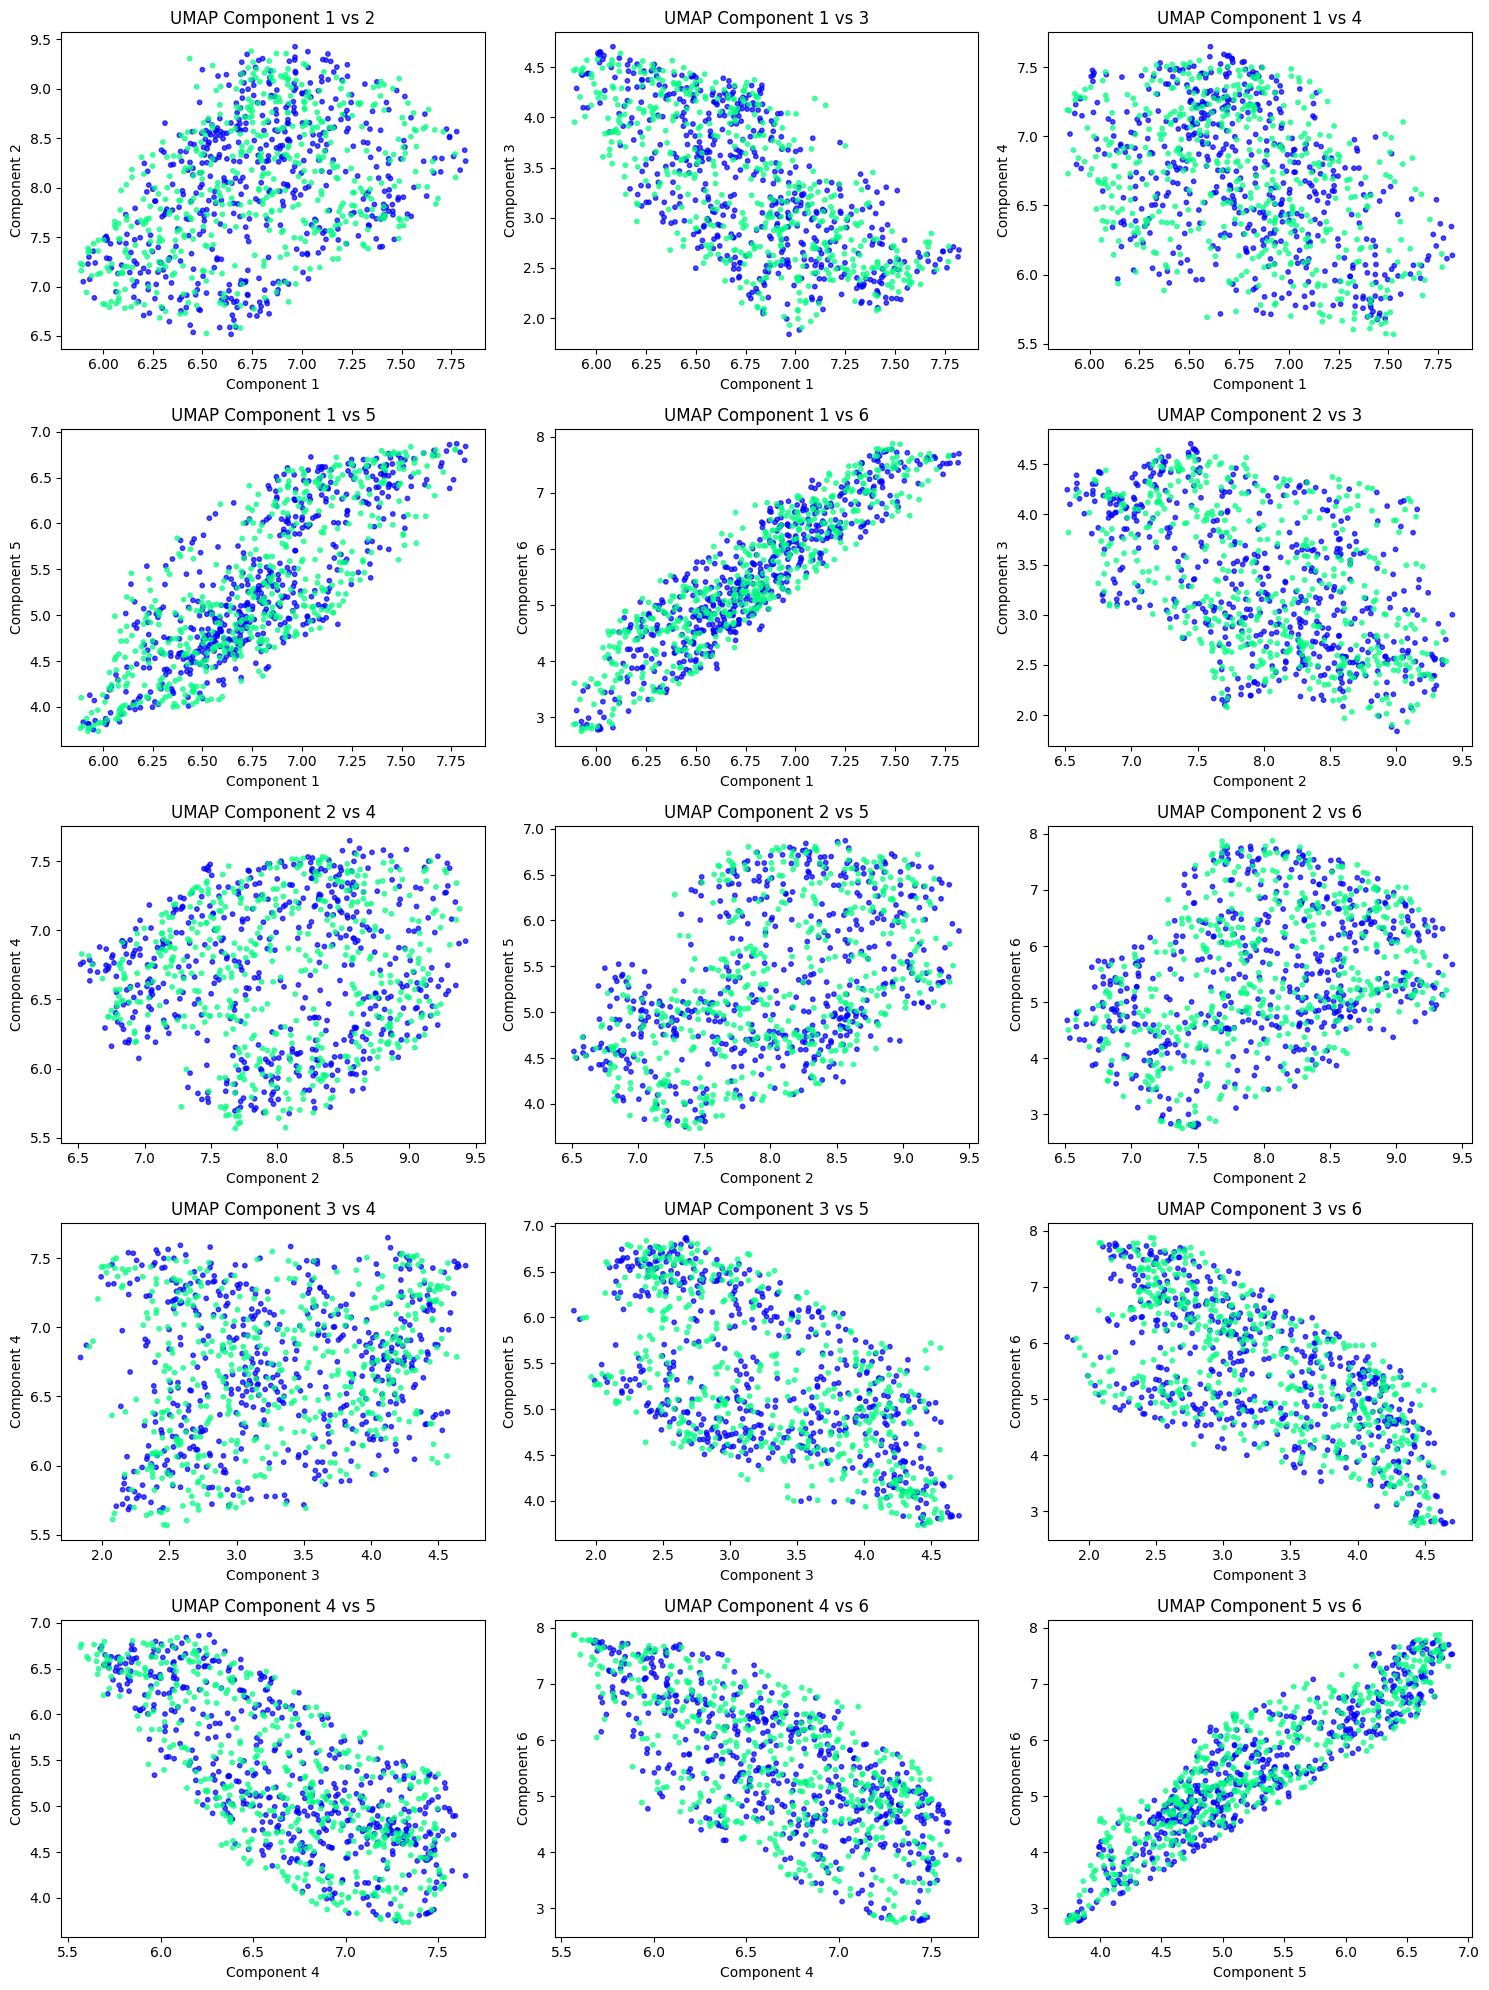

In [5]:
import os
import umap
from torchvision import datasets, transforms
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, NMF


# Step 1: Define transformations for Tiny ImageNet dataset
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Tiny ImageNet images are 64x64 pixels
    transforms.ToTensor(),
])

# Step 2: Specify the path to the Tiny ImageNet training dataset
data_path = 'tiny-imagenet-200/train'  # Replace with your actual path

# Step 3: Load the dataset using ImageFolder
imagenet_data = datasets.ImageFolder(data_path, transform=transform)

# Step 4: Identify the first two classes
classes = imagenet_data.classes  # List of class names sorted alphabetically
first_two_classes = ['n02124075', 'n03617480']
print(f"Selected Classes: {first_two_classes}")

# Step 5: Get the class indices for the first two classes
class_indices = [imagenet_data.class_to_idx[cls] for cls in first_two_classes]
print(f"Class Indices: {class_indices}")

# Step 6: Filter the dataset to include only the first two classes
# Find the indices of samples that belong to the first two classes
filtered_indices = [
    i for i, (_, label) in enumerate(imagenet_data.samples)
    if label in class_indices
]

# Create a subset of the dataset with only the filtered samples
subset = torch.utils.data.Subset(imagenet_data, filtered_indices)

# Step 7: Create a DataLoader for the subset
dataloader = torch.utils.data.DataLoader(subset, batch_size=64, shuffle=False)

# Step 8: Collect images and labels from the subset
images = []
labels = []
for batch in dataloader:
    imgs, lbls = batch
    imgs = imgs.view(imgs.size(0), -1)  # Flatten images to 1D vectors
    images.append(imgs.numpy())
    labels.append(lbls.numpy())

# Concatenate all batches
images = np.vstack(images)
labels = np.hstack(labels)

print(f"Total samples after filtering: {images.shape[0]}")

# Optional: Normalize the images (UMAP can benefit from normalized data)
# Here, we scale pixel values to [0, 1] already via ToTensor(), but further normalization can be applied if needed.

# Step 9: Apply UMAP to reduce dimensions to 6
umap_model = umap.UMAP(n_components=6, n_neighbors=15, min_dist=0.1, random_state=123)
pca = PCA(n_components=6)
nmf = NMF(n_components=6, init='random', random_state=123)

reduced_data = umap_model.fit_transform(images)

print(f"Reduced data shape: {reduced_data.shape}")

# Step 10: Visualize the first two UMAP components
fig, axes = plt.subplots(5,3, figsize=(15,20))

# Generate all pairs of components (combinations)
component_pairs = [(i, j) for i in range(6) for j in range(i+1, 6)]

# Plot each pair in a subplot
for idx, (i, j) in enumerate(component_pairs):
    ax = axes[idx // 3, idx % 3]
    scatter = ax.scatter(
        reduced_data[:, i],  # UMAP component i
        reduced_data[:, j],  # UMAP component j
        c=labels,            # Color by class label
        cmap='winter',
        s=10,
        alpha=0.7
    )
    ax.set_title(f'UMAP Component {i+1} vs {j+1}')
    ax.set_xlabel(f'Component {i+1}')
    ax.set_ylabel(f'Component {j+1}')

# Adjust layout
plt.tight_layout()
plt.show()
